## Bibliotecas

In [102]:
import pandas as pd
import numpy as np
import datetime as dt

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm


from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score


from google.colab                import drive

In [103]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [104]:
df_segmentacao = pd.read_excel('/content/gdrive/MyDrive/Colab Notebooks/Segmentação de Clientes/online_retail_II.xlsx')
df_segmentacao.shape

(525461, 8)

In [105]:
df_segmentacao.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [106]:
df_segmentacao.tail()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
525456,538171,22271,FELTCRAFT DOLL ROSIE,2,2010-12-09 20:01:00,2.95,17530.0,United Kingdom
525457,538171,22750,FELTCRAFT PRINCESS LOLA DOLL,1,2010-12-09 20:01:00,3.75,17530.0,United Kingdom
525458,538171,22751,FELTCRAFT PRINCESS OLIVIA DOLL,1,2010-12-09 20:01:00,3.75,17530.0,United Kingdom
525459,538171,20970,PINK FLORAL FELTCRAFT SHOULDER BAG,2,2010-12-09 20:01:00,3.75,17530.0,United Kingdom
525460,538171,21931,JUMBO STORAGE BAG SUKI,2,2010-12-09 20:01:00,1.95,17530.0,United Kingdom


In [107]:
df_segmentacao.dtypes

Invoice                object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
Price                 float64
Customer ID           float64
Country                object
dtype: object

## Tratamento de dados

In [108]:
#Retiramos dados nulos de consumidores
df_segmentacao = df_segmentacao[~df_segmentacao['Customer ID'].isna()].drop('Description', axis=1)

In [109]:
#Verificamos que existem quantidades negativas de compras
df_segmentacao = df_segmentacao[~df_segmentacao['Quantity'] < 1]

In [110]:
#Retiramos dados de clientes que tiveram compra com valor nulo
df_segmentacao = df_segmentacao[df_segmentacao['Price'] != 0]

In [111]:
#Intervalo de tempo da base de dados
df_segmentacao['InvoiceDate'].agg(['min', 'max'])

#A data máxima será a medida final do intervalo de recencia
data_máxima = max(df_segmentacao['InvoiceDate'])

In [112]:
df_segmentacao['Customer ID'] = df_segmentacao['Customer ID'].astype(int).astype(str)
df_segmentacao.shape

(411981, 7)

In [113]:
#Quantidade de clientes únicos pertencentes a base de dados
len(df_segmentacao['Customer ID'].unique().tolist())

4362

In [114]:
df_segmentacao.dtypes

Invoice                object
StockCode              object
Quantity                int64
InvoiceDate    datetime64[ns]
Price                 float64
Customer ID            object
Country                object
dtype: object

In [115]:
#Criar análise de RFM para a base de clientes
df_segmentacao['Amount'] = df_segmentacao['Price'] * df_segmentacao['Quantity']

In [116]:
df_segmentacao.columns

Index(['Invoice', 'StockCode', 'Quantity', 'InvoiceDate', 'Price',
       'Customer ID', 'Country', 'Amount'],
      dtype='object')

## RFM Analytcs

In [117]:
#Cria feature de montante transacionado
df_monetary = df_segmentacao.groupby('Customer ID')['Amount'].sum().reset_index().rename({'Amount':'Montante'}, axis = 1)

#Cria feature de invoice consumida
df_frequency = df_segmentacao.groupby('Customer ID')['Invoice'].count().reset_index().rename({'Invoice':'Frequencia'}, axis = 1)

#Junta as features tratadas
rfm_dataframe = df_monetary.merge(df_frequency, on='Customer ID')

In [118]:
#Trazer feature de recência de cada consumidor
df_segmentacao['Recencia'] = data_máxima - df_segmentacao['InvoiceDate']

#Buscamos a data mínima em dias de cada cliente
df_recency = df_segmentacao.groupby('Customer ID')['Recencia'].min().reset_index()

#Tratamos a data
df_recency['Recencia'] = df_recency['Recencia'].dt.days

#Junta as features tratadas
rfm_dataframe = rfm_dataframe.merge(df_recency, on='Customer ID')

In [119]:
#Iremos calcular o indicador de lifetime value de cada cliente
df_ticket = df_segmentacao.groupby('Customer ID')['Amount'].mean().reset_index().rename({'Amount':'Ticket_medio'}, axis =1)

#Adicionamos a feature de ticket médio no dataframe da análise RFM
rfm_dataframe = rfm_dataframe.merge(df_ticket, on='Customer ID')

In [120]:
#Para calcularmpos a rentenção do cliente, iremos calcular a quantidade de meses que ele esteva tivo na nossa empresa, isto é, a quantidade de meses que ele realizou ao menos uma compra
df_segmentacao['Safra'] = df_segmentacao['InvoiceDate'].dt.to_period('M')
df_rentecao = df_segmentacao.groupby('Customer ID')['Safra'].nunique().reset_index().rename({'Safra':'Retencao'}, axis =1)

#Adicionamos a feature de retenção no dataframe da análise RFM
rfm_dataframe = rfm_dataframe.merge(df_rentecao, on='Customer ID')

In [121]:
#Por conseguinte, temos todas os atributos para calcularmos o life time value
rfm_dataframe['LTV'] = rfm_dataframe['Frequencia'] * rfm_dataframe['Retencao'] * rfm_dataframe['Ticket_medio']

In [122]:
rfm_dataframe.head()

,Customer ID,Montante,Frequencia,Recencia,Ticket_medio,Retencao,LTV
0,12346,27.02,44,66,0.614091,5,135.10
1,12347,1323.32,71,2,18.638310,2,2646.64
2,12348,222.16,20,73,11.108000,1,222.16
3,12349,2646.99,107,42,24.738224,4,10587.96
4,12351,300.93,21,10,14.330000,1,300.93


In [123]:
# Remoção de outliers
Q1 = rfm_dataframe.Montante.quantile(0.05)
Q3 = rfm_dataframe.Montante.quantile(0.95)
IQR = Q3 - Q1
rfm_dataframe = rfm_dataframe[(rfm_dataframe.Montante >= Q1 - 1.5*IQR) & (rfm_dataframe.Montante <= Q3 + 1.5*IQR)]

Q1 = rfm_dataframe.Recencia.quantile(0.05)
Q3 = rfm_dataframe.Recencia.quantile(0.95)
IQR = Q3 - Q1
rfm_dataframe = rfm_dataframe[(rfm_dataframe.Recencia >= Q1 - 1.5*IQR) & (rfm_dataframe.Recencia <= Q3 + 1.5*IQR)]

Q1 = rfm_dataframe.Frequencia.quantile(0.05)
Q3 = rfm_dataframe.Frequencia.quantile(0.95)
IQR = Q3 - Q1
rfm_dataframe = rfm_dataframe[(rfm_dataframe.Frequencia >= Q1 - 1.5*IQR) & (rfm_dataframe.Frequencia <= Q3 + 1.5*IQR)]

In [124]:
len(rfm_dataframe['Customer ID'].unique().tolist())

4277

In [125]:
rfm_dataframe.head()

,Customer ID,Montante,Frequencia,Recencia,Ticket_medio,Retencao,LTV
0,12346,27.02,44,66,0.614091,5,135.10
1,12347,1323.32,71,2,18.638310,2,2646.64
2,12348,222.16,20,73,11.108000,1,222.16
3,12349,2646.99,107,42,24.738224,4,10587.96
4,12351,300.93,21,10,14.330000,1,300.93


## Clustering K-Means

In [126]:
#Base de dados que será utilizado para o modelo de K-Means
df_model = rfm_dataframe[['Customer ID','Montante', 'Frequencia', 'Recencia','LTV']]
df_model.head()

,Customer ID,Montante,Frequencia,Recencia,LTV
0,12346,27.02,44,66,135.10
1,12347,1323.32,71,2,2646.64
2,12348,222.16,20,73,222.16
3,12349,2646.99,107,42,10587.96
4,12351,300.93,21,10,300.93


### Normalização de dados

In [127]:
#Normalização de dados

#Escalonamento de atributos
escalonamento = MinMaxScaler((0,1)) 

df_rfm = df_model[['Montante','Recencia','Frequencia','LTV']]
rfm = escalonamento.fit_transform(df_rfm)
rfm

array([[0.28765937, 0.1769437 , 0.06022409, 0.07967778],
       [0.35082558, 0.00536193, 0.09803922, 0.09283979],
       [0.29716817, 0.19571046, 0.02661064, 0.08013403],
       ...,
       [0.30714963, 0.79088472, 0.01540616, 0.08120751],
       [0.34951528, 0.29758713, 0.09243697, 0.09255795],
       [0.40064467, 0.04557641, 0.11764706, 0.11584866]])

### Busca de melhores parâmetros 

In [128]:
k_means = KMeans(n_clusters = 10)
k_clusters = k_means.fit(rfm)

print(k_clusters.n_clusters)

10


In [129]:
cl = 20
corte = 0.1

anterior = 100000000000000
cost = [] 
K_best = cl

for k in range (1, cl+1):
    model = KMeans(
        n_clusters=k, 
        init='k-means++', 
        n_init=10, #Definimos a inicialização 
        max_iter=300, #Setamos o número máximo de interações para o modelo
        random_state=42) #Relacionamos o número da semente para sempre rodar o mesmo resultado

    model = model.fit(rfm)
    labels = model.labels_
 
    # Calculamos a reta de dois pontos em relação a cada ponto da cusva
    interia = model.inertia_
    if (K_best == cl) and (((anterior - interia)/anterior) < corte): K_best = k - 1
    cost.append(interia)
    anterior = interia

### Treino K-Means

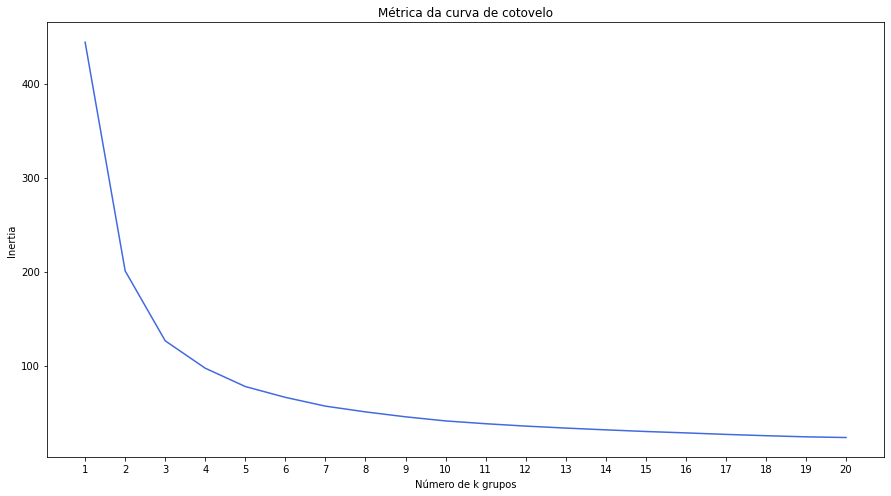

In [130]:
f, ax = plt.subplots(figsize=(15, 8))
plt.plot(range(1, cl+1), cost, '-0', c='royalblue')
plt.xlabel('Número de k grupos')
plt.ylabel('Inertia')
plt.xticks(range(1, cl+1))
#plt.style.use('ggplot')
plt.title('Métrica da curva de cotovelo')
plt.show()

In [131]:
#Após validação do modelo de acordo com os melhores parâmetros encontrados
  #Criamos e rodamos um novo modelo para gerar o melhor resultado de acordo com o melhor número de clusters encontrado no cálculos da curva
print('The best K sugest: ', K_best)
model = KMeans(n_clusters=K_best, init='k-means++', n_init=10, max_iter=300, random_state=42)
model = model.fit(rfm)
labels = model.labels_

The best K sugest:  9


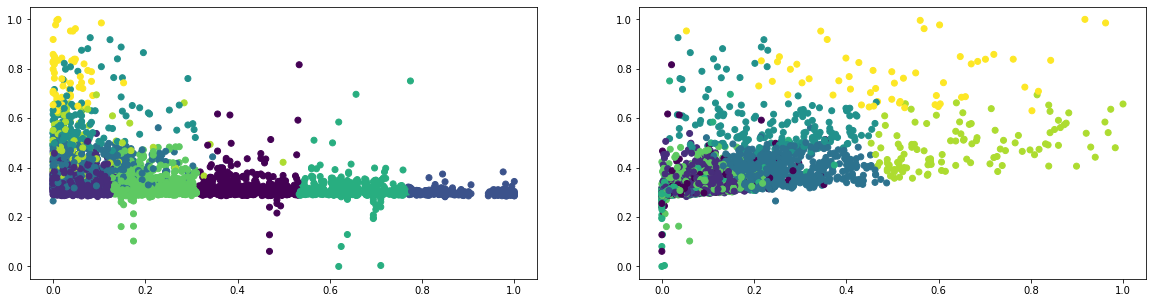

In [132]:
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(121)

plt.scatter(x = rfm[:,1], y = rfm[:,0], c=model.labels_.astype(float))
#ax.set_xlabel(atributos[1])
#ax.set_ylabel(atributos[0])
ax = fig.add_subplot(122)
plt.scatter(x = rfm[:,2], y = rfm[:,0], c=model.labels_.astype(float))
#ax.set_xlabel(atributos[2])
#ax.set_ylabel(atributos[0])

plt.show()

In [133]:
df_model['Segmentacao'] = labels + 1
df_model.head()

<ipython-input-133-97075f73c8b5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model['Segmentacao'] = labels + 1


,Customer ID,Montante,Frequencia,Recencia,LTV,Segmentacao
0,12346,27.02,44,66,135.10,7
1,12347,1323.32,71,2,2646.64,2
2,12348,222.16,20,73,222.16,7
3,12349,2646.99,107,42,10587.96,4
4,12351,300.93,21,10,300.93,2


In [134]:
tabela_segmentacao = df_model[['Segmentacao','Montante','Recencia','Frequencia','LTV']].groupby('Segmentacao').agg(['mean','count','max']).round()

In [135]:
tabela_segmentacao

Montante                Recencia            Frequencia             \
                mean count      max     mean count  max       mean count  max   
Segmentacao                                                                     
1              673.0   461  10877.0    159.0   461  199       38.0   461  254   
2              825.0  1266   5169.0     21.0  1266   49       46.0  1266  131   
3              264.0   284   1976.0    332.0   284  373       19.0   284  113   
4             2200.0   561   5646.0     27.0   561  136      181.0   561  349   
5             6006.0   169  13125.0     22.0   169  115      174.0   169  333   
6              457.0   445   9530.0    240.0   445  289       30.0   445  268   
7              775.0   921   4067.0     75.0   921  116       42.0   921  186   
8             4045.0   114   8377.0     22.0   114  186      467.0   114  715   
9            10030.0    56  14646.0     12.0    56   57      364.0    56  688   

                  LTV                  
                 mean count       max  
Segmentacao                            
1              1796.0   461   37643.0  
2              2780.0  1266   28214.0  
3               307.0   284    2996.0  
4             11996.0   561   32704.0  
5             43730.0   169  103320.0  
6              1004.0   445   33686.0  
7              2338.0   921   29777.0  
8             31395.0   114   78978.0  
9            102800.0    56  175749.0

## Análise de grupos

O que podemos analisar é que possuímos três grupos de clientes muito ativos financeiramente na nossa empresa, respectivamente, temos o grupo 9, que apresenta a maior média transacionada, segunda maior frequência e maior custo de vida no nosso estabelecimento. Em contraste a ele, porém com comportamentos parecidos, são os consumidores pertencentes aos grupos 8 e 5, no qual são definidos por uma recência praticamente equivalente, seguidos por colocações de segundo e terceiro lugar com maior média de montante transacionado. 

Iremos denominar eles como:
* Grupo 9: Campeões
* Grupo 8: Fieis 
* Grupo 7: Casuais Campeões

Outro grupo com característica interessante, é o grupo 2, possui compras recentes, são clientes que possuem uma carteira alta, apresentam um comportamento de compra não tão frequente, podemos considerar eles como novos clientes.

Iremos denominar eles como:
* Grupo 9: Campeões
* Grupo 8: Fieis 
* Grupo 7: Casuais Campeões
* Grupo 2: Novos clientes

Agora, precisamos encontrar aqueles clientes pontuais, que denominaremos como clientes casuais, são clientes que apresentam uma frequencia e recência de compras próxima, aqui, não iremos olhar montante e custo de vida.

Iremos denominar eles como:
* Grupo 9: Campeões
* Grupo 8: Fieis 
* Grupo 7: Casuais Campeões
* Grupo 2: Novos clientes
* Grupo 5 e 4: Casuais
* Grupo 1, 3 e 6: Sumidos

In [136]:
df_model['Grupos'] = df_model['Segmentacao'].replace({1:'Sumidos',
                                           3:'Sumidos',
                                           6:'Sumidos',
                                           5:'Casuais',
                                           4:'Casuais',
                                           2:'Novos clientes',
                                           7:'Casuais campeões',
                                           8:'Fieis',
                                           9:'Campões'})


df_model['Grupos_num'] = df_model['Segmentacao'].replace({1:1,
                                           3:1,
                                           6:1,
                                           5:2,
                                           4:2,
                                           2:3,
                                           7:4,
                                           8:5,
                                           9:6})

In [137]:
df_model['Grupos'].head()

0    Casuais campeões
1      Novos clientes
2    Casuais campeões
3             Casuais
4      Novos clientes
Name: Grupos, dtype: object

In [138]:
df_model[['Grupos','Montante','Recencia','Frequencia','LTV']].groupby('Grupos').agg(['mean','count','max']).round()

Montante                Recencia            Frequencia        \
                     mean count      max     mean count  max       mean count   
Grupos                                                                          
Campões           10030.0    56  14646.0     12.0    56   57      364.0    56   
Casuais            3081.0   730  13125.0     25.0   730  136      179.0   730   
Casuais campeões    775.0   921   4067.0     75.0   921  116       42.0   921   
Fieis              4045.0   114   8377.0     22.0   114  186      467.0   114   
Novos clientes      825.0  1266   5169.0     21.0  1266   49       46.0  1266   
Sumidos             494.0  1190  10877.0    231.0  1190  373       30.0  1190   

                            LTV                  
                  max      mean count       max  
Grupos                                           
Campões           688  102800.0    56  175749.0  
Casuais           349   19342.0   730  103320.0  
Casuais campeões  186    2338.0   921   29777.0  
Fieis             715   31395.0   114   78978.0  
Novos clientes    131    2780.0  1266   28214.0  
Sumidos           268    1144.0  1190   37643.0

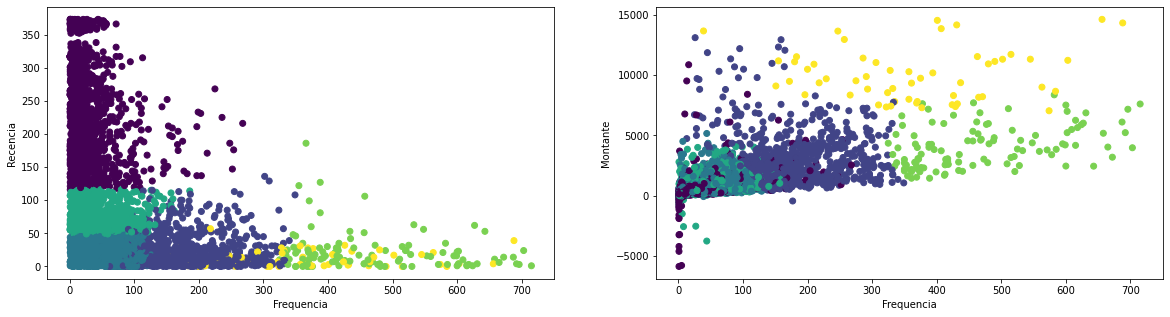

In [139]:
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(121)
plt.scatter(x = df_model['Frequencia'], y = df_model['Recencia'], c=df_model['Grupos_num'])
ax.set_xlabel('Frequencia')
ax.set_ylabel('Recencia')

ax = fig.add_subplot(122)
plt.scatter(x = df_model['Frequencia'], y = df_model['Montante'], c=df_model['Grupos_num'])
ax.set_xlabel('Frequencia')
ax.set_ylabel('Montante')
plt.show()

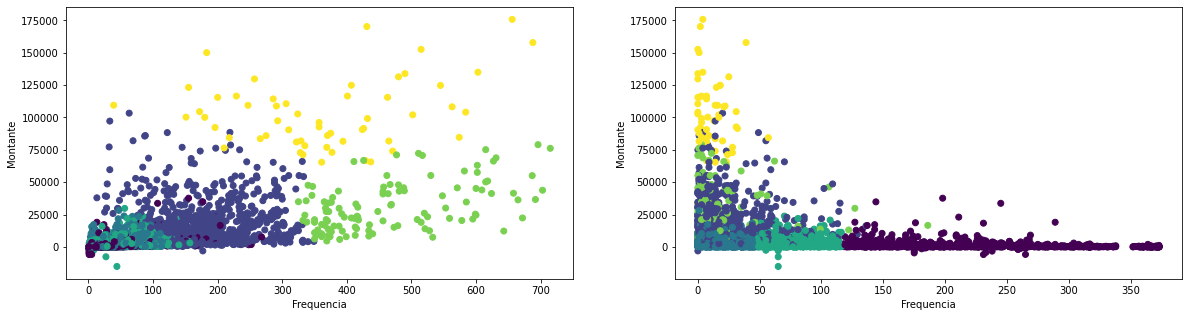

In [141]:
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(121)
plt.scatter(x = df_model['Frequencia'], y = df_model['LTV'], c=df_model['Grupos_num'])
ax.set_xlabel('Frequencia')
ax.set_ylabel('Montante')

ax = fig.add_subplot(122)
plt.scatter(x = df_model['Recencia'], y = df_model['LTV'], c=df_model['Grupos_num'])
ax.set_xlabel('Frequencia')
ax.set_ylabel('Montante')
plt.show()